# 1 Data Wrangling

## Environment

### Env

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import os
from dotenv import load_dotenv

load_dotenv()

True

In [8]:
# Files
DATA_PATH = '../data'

os.listdir(DATA_PATH)

['.DS_Store',
 'internal_tagged_slip_lanes',
 'network-link-volumes_fall-2023_alameda',
 'Slip Lanes Communal Search Project.kmz']

### Make SQL Connections

In [9]:
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import text

user = "postgres"
password = os.getenv('POSTGRES_PW')
host = "127.0.0.1"
port = "5432"
database = "gradschool"

pg_url = URL.create(
    drivername='postgresql',
    username='postgres',
    host='127.0.0.1',
    database='gradschool',
    password=os.getenv('POSTGRES_PW')
)

pg_engine = create_engine(pg_url)
# Test connection
try:
    with pg_engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

pg_connection = pg_engine.connect()

Successfully connected to the PostgreSQL database


## Files to Load

* **CA Block Groups**
- Basefile

* **Slip Lanes KML**
    - import from download
    - convert to shapefile
    - clean
    - buffer-ize

* **Replica link data**

* **Alameda County ___**

* **TIMS SafeTREC**
    - connect directly to SafeTREC server

### Load CA BGs (Test File)

In [10]:
# Load Test File of CA bgs
shp_tl_CA_bgs_2020 = gpd.read_postgis(text('SELECT * FROM "mapping_basefiles"."tl_CA_bgs_2020";'), con = pg_connection)

### Load MyMaps (Slip Lanes KML)
Load Slip lanes from [Communal Slip Lane Map](https://www.google.com/maps/d/u/2/edit?mid=1Fnhv4nUwpqsED9yI65fx0NwPYv0mNtY&ll=37.787159702062866%2C-122.28705144048187&z=13).

Output: `gdf_tagged_slip_lanes`


Notes on Key:

* 

In [11]:
# Load kml

# Load File
!pip install zipfile36
from zipfile import ZipFile
import fiona
os.listdir(DATA_PATH)

# Set File Paths
kmz_file_path = os.path.join(DATA_PATH, 'Slip Lanes Communal Search Project.kmz')
kmz_extraction_dir = os.path.join(DATA_PATH, 'internal_tagged_slip_lanes')
if not os.path.exists(kmz_extraction_dir):
    os.mkdir(kmz_extraction_dir)

# Extract into new directory
with ZipFile(kmz_file_path, "r") as kmz:
    kmz.extractall(kmz_extraction_dir)


In [12]:
# Check what's in there
print(os.listdir(kmz_extraction_dir))

# Necessary driver settings for fiona (party of GPD)
fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Look at the file
extracted_kml = os.path.join(kmz_extraction_dir,'doc.kml')
print(fiona.listlayers(extracted_kml))

# Go layer by layer
gdf_dict = {}
for layer in fiona.listlayers(extracted_kml):
    gdf = gpd.read_file(extracted_kml, driver='libkml', layer=layer)
    gdf_dict[layer] = gdf


#gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

['.DS_Store', 'images', 'doc.kml']
['Berkeley Slip Lanes', 'Potential Slip Lanes', 'Oakland Potential Slip Lanes', 'Other Alameda County', 'Former Slip Lanes - From Chuck', 'Additional Oakland Slip Lanes (from RP)']


In [13]:
# Concatenate dictionary of dataframes together, but keep the layer name as a column
gdf_tagged_slip_lanes = pd.concat(gdf_dict, names=['Layer']).reset_index(level=0).reset_index(drop=True)
gdf_tagged_slip_lanes

,Layer,Name,Description,geometry
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),,POINT Z (-122.26849 37.85507 0)
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),,POINT Z (-122.26954 37.85432 0)
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,,POINT Z (-122.27875 37.88729 0)
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),,POINT Z (-122.27873 37.88933 0)
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,,POINT Z (-122.27229 37.88909 0)
...,...,...,...,...
348,Additional Oakland Slip Lanes (from RP),**Mountain Blvd -> Redwood Rd,,POINT Z (-122.18301 37.79669 0)
349,Additional Oakland Slip Lanes (from RP),**Carson St -> Tompkins Ave,,POINT Z (-122.18604 37.7899 0)
350,Additional Oakland Slip Lanes (from RP),**Hawley St -> 73rd Ave,,POINT Z (-122.19412 37.75456 0)
351,Additional Oakland Slip Lanes (from RP),**Harbord Dr -> Broadway Terrace,i think we might not consider this slip but ju...,POINT Z (-122.23627 37.84113 0)


In [14]:
# Clean Slip Lanes

# Goals:
# - split off prepend to categorize them
# - split name into start and end street

# Look for prepends
gdf_tagged_slip_lanes['Active'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^##', regex=True), False, True)
gdf_tagged_slip_lanes['Is_SlipLane'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^!!', regex=True), False, True)
gdf_tagged_slip_lanes['Has_Questions'] = np.where(gdf_tagged_slip_lanes['Name'].str.contains('^\\?\\?', regex=True), True, False)


#gdf_tagged_slip_lanes.Name.str.split(' -> ', n=1, expand=True)
# Split on ->
#gdf_tagged_slip_lanes.Name.str.split(r'(?<=\D)(?=\d)', expand=True, n=1)

#pattern = r"(.*) -> (.*) \((.*)\)$"
pattern = r"^(.*) -> (.*?)(?: \((.*)\))?$"

#gdf_tagged_slip_lanes.Name.str.extract('(\w+\s+)')
gdf_tagged_slip_lanes[['o_road', 'd_road', 'crdnl_loc']] = gdf_tagged_slip_lanes['Name'].str.replace(r'^(##|!!|\?\? |\*\*)\s*', '', regex=True).str.extract(pattern)
gdf_tagged_slip_lanes['Name_clean'] = gdf_tagged_slip_lanes['Name'].str.replace(r'^(##|!!|\?\?|\*\*)\s*', '', regex=True)

# Extract (DIR) into its own column
# Remove prepend

In [63]:
gdf_tagged_slip_lanes

,Layer,Name,Description,geometry,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),,POINT Z (-122.26849 37.85507 0),True,True,False,Ashby Ave,Adeline St,NE,Ashby Ave -> Adeline St (NE)
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),,POINT Z (-122.26954 37.85432 0),True,True,False,Ashby Ave,Adeline St,SW,Ashby Ave -> Adeline St (SW)
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,,POINT Z (-122.27875 37.88729 0),True,True,False,Colusa Ave,Monterey Ave,NaN,Colusa Ave -> Monterey Ave
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),,POINT Z (-122.27873 37.88933 0),True,True,False,Colusa Ave,Marin Ave,SE,Colusa Ave -> Marin Ave (SE)
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,,POINT Z (-122.27229 37.88909 0),True,True,False,Del Norte St,Sutter St,NaN,Del Norte St -> Sutter St
...,...,...,...,...,...,...,...,...,...,...,...
348,Additional Oakland Slip Lanes (from RP),**Mountain Blvd -> Redwood Rd,,POINT Z (-122.18301 37.79669 0),True,True,False,Mountain Blvd,Redwood Rd,NaN,Mountain Blvd -> Redwood Rd
349,Additional Oakland Slip Lanes (from RP),**Carson St -> Tompkins Ave,,POINT Z (-122.18604 37.7899 0),True,True,False,Carson St,Tompkins Ave,NaN,Carson St -> Tompkins Ave
350,Additional Oakland Slip Lanes (from RP),**Hawley St -> 73rd Ave,,POINT Z (-122.19412 37.75456 0),True,True,False,Hawley St,73rd Ave,NaN,Hawley St -> 73rd Ave
351,Additional Oakland Slip Lanes (from RP),**Harbord Dr -> Broadway Terrace,i think we might not consider this slip but ju...,POINT Z (-122.23627 37.84113 0),True,True,False,Harbord Dr,Broadway Terrace,NaN,Harbord Dr -> Broadway Terrace


In [13]:
gdf_tagged_slip_lanes['Valid'] = (gdf_tagged_slip_lanes['Active'] & 
                                  gdf_tagged_slip_lanes['Is_SlipLane'] & 
                                  ~gdf_tagged_slip_lanes['Has_Questions'] & 
                                  gdf_tagged_slip_lanes['Layer'].isin(['Berkeley Slip Lanes', 'Oakland Potential Slip Lanes', 'Additional Oakland Slip Lanes (from RP)']))

gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']]

gdf_tagged_slip_lanes

,Layer,Name,Description,geometry,Active,Is_SlipLane,Has_Questions,o_road,d_road,crdnl_loc,Name_clean,Valid
0,Berkeley Slip Lanes,Ashby Ave -> Adeline St (NE),,POINT Z (-122.26849 37.85507 0),True,True,False,Ashby Ave,Adeline St,NE,Ashby Ave -> Adeline St (NE),True
1,Berkeley Slip Lanes,Ashby Ave -> Adeline St (SW),,POINT Z (-122.26954 37.85432 0),True,True,False,Ashby Ave,Adeline St,SW,Ashby Ave -> Adeline St (SW),True
2,Berkeley Slip Lanes,Colusa Ave -> Monterey Ave,,POINT Z (-122.27875 37.88729 0),True,True,False,Colusa Ave,Monterey Ave,NaN,Colusa Ave -> Monterey Ave,True
3,Berkeley Slip Lanes,Colusa Ave -> Marin Ave (SE),,POINT Z (-122.27873 37.88933 0),True,True,False,Colusa Ave,Marin Ave,SE,Colusa Ave -> Marin Ave (SE),True
4,Berkeley Slip Lanes,Del Norte St -> Sutter St,,POINT Z (-122.27229 37.88909 0),True,True,False,Del Norte St,Sutter St,NaN,Del Norte St -> Sutter St,True
...,...,...,...,...,...,...,...,...,...,...,...,...
348,Additional Oakland Slip Lanes (from RP),**Mountain Blvd -> Redwood Rd,,POINT Z (-122.18301 37.79669 0),True,True,False,Mountain Blvd,Redwood Rd,NaN,Mountain Blvd -> Redwood Rd,True
349,Additional Oakland Slip Lanes (from RP),**Carson St -> Tompkins Ave,,POINT Z (-122.18604 37.7899 0),True,True,False,Carson St,Tompkins Ave,NaN,Carson St -> Tompkins Ave,True
350,Additional Oakland Slip Lanes (from RP),**Hawley St -> 73rd Ave,,POINT Z (-122.19412 37.75456 0),True,True,False,Hawley St,73rd Ave,NaN,Hawley St -> 73rd Ave,True
351,Additional Oakland Slip Lanes (from RP),**Harbord Dr -> Broadway Terrace,i think we might not consider this slip but ju...,POINT Z (-122.23627 37.84113 0),True,True,False,Harbord Dr,Broadway Terrace,NaN,Harbord Dr -> Broadway Terrace,True


In [68]:
# Write to postgis
# gdf_tagged_slip_lanes.to_postgis('alameda_tagged_slip_lanes_clean', con = pg_connection, schema='slip_lanes', if_exists = 'replace')


### Load Replica (Modeled) Link Volumes

Load Replica data for Network Link Volumes for Alameda County (Fall 2023). Note we already have it in postgres so I'm gonna load it from there but its also in a csv or can be recreated on the Replica engine

In [60]:
# Load replica
os.listdir(DATA_PATH)

#gdf_network_link_volumes = gpd.read_file(os.path.join(DATA_PATH,'network-link-volumes_fall-2023_alameda'))
#gdf_network_link_volumes.to_postgis('replica_netlinkvols_alameda_fall2023', con=pg_connection, schema = 'slip_lanes')


### Load SWITRS Collision Data

SWITRS - Pull from SQLServer/Write to PG (with some cleaning)

In [24]:
# Pull from SWITRS
TIMS_QUERY = """select 
    CASE_ID,
    COUNTY,
    CITY,
    -- Time
    ACCIDENT_YEAR,
    COLLISION_DATE,
    COLLISION_TIME, -- <- data-time,
    DAY_OF_WEEK,
    -- Location
    PRIMARY_RD,
    SECONDARY_RD,
    DISTANCE,
    DIRECTION
    -- Conditions
    INTERSECTION,
    WEATHER_1,
    WEATHER_2,
    -- Factors
    PRIMARY_COLL_FACTOR,
    PCF_VIOL_CATEGORY,
    TYPE_OF_COLLISION,
    LIGHTING,
    PEDESTRIAN_ACCIDENT,
    BICYCLE_ACCIDENT,
    TRUCK_ACCIDENT,
    STWD_VEHTYPE_AT_FAULT,
    -- Injuries
    COLLISION_SEVERITY,
    NUMBER_KILLED,
    NUMBER_INJURED,
    PARTY_COUNT,
    -- Kills
    COUNT_PED_KILLED,
    COUNT_BICYCLIST_KILLED,
    -- GEOM
    POINT_X,
    POINT_Y
from 
    switrs
where 
    COUNTY = 'ALAMEDA' and CITY in ('OAKLAND', 'BERKELEY')
;
"""

In [26]:
# # mk db connection
tims_url = URL.create(
    drivername='mssql+pymssql',
    username='safetrec_app',
    host='sql-dnon01.ist.berkeley.edu',
    database='SAFETREC_TIMS',
    password=os.getenv('SAFETREC_PW')
)

# Connect to TIMS Query
import pymssql
tims_engine = create_engine(tims_url)

# engine = create_engine(tims_url)
with tims_engine.connect() as conn, conn.begin():
    df_TIMS = pd.read_sql_query(sql=text(TIMS_QUERY), con=conn)
    print('crash data collected')

crash data collected


In [49]:
# Convert df_TIMS -> gdf
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_TIMS.POINT_X, df_TIMS.POINT_Y)]
gdf_TIMS = GeoDataFrame(df_TIMS.drop(['POINT_X', 'POINT_Y'], axis=1), crs="EPSG:4326", geometry=geometry)

In [50]:
# !pip install --upgrade SQLAlchemy==1.4.46
#!pip install --upgrade GeoPandas
import sqlalchemy
!pip install geoalchemy2
from geoalchemy2 import Geometry, WKTElement
gdf_TIMS_2 = gdf_TIMS
gdf_TIMS_2['geom'] = gdf_TIMS_2['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
                                                  
#drop the geometry column as it is now duplicative
gdf_TIMS_2.drop('geometry', 1, inplace=True)

gdf_TIMS_2.to_sql('TIMS_oakland_berkeley', con = pg_connection, schema='slip_lanes', if_exists='replace', dtype= {'geom': Geometry('POINT', srid = 4326)}, index=False)
#gdf_TIMS.to_postgis('TIMS_oakland_berkeley', con=pg_connection, schema = 'slip_lanes')
#gdf_TIMS = gpd.GeoDataFrame.from_postgis('select *, geometry as geom from slip_lanes.tims_oakberk;', con=pg_connection) #
#, schema='slip_lanes', if_exists = 'replace') ### NO CAPITAL LETTERS

#sum(gdf_TIMS.is_empty)/len(gdf_TIMS) # 3% are empty

#gdf_TIMS.to_postgis('tims_oakberk', con=pg_connection, schema='slip_lanes', if_exists = 'replace') ### NO CAPITAL LETTERS

/var/folders/t8/dm9l8xy95mv0d_75b2m8r5nw0000gn/T/ipykernel_71383/2988039260.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gdf_TIMS_2.drop('geometry', 1, inplace=True)


635

## Visualize together

KeyError: 'Valid'

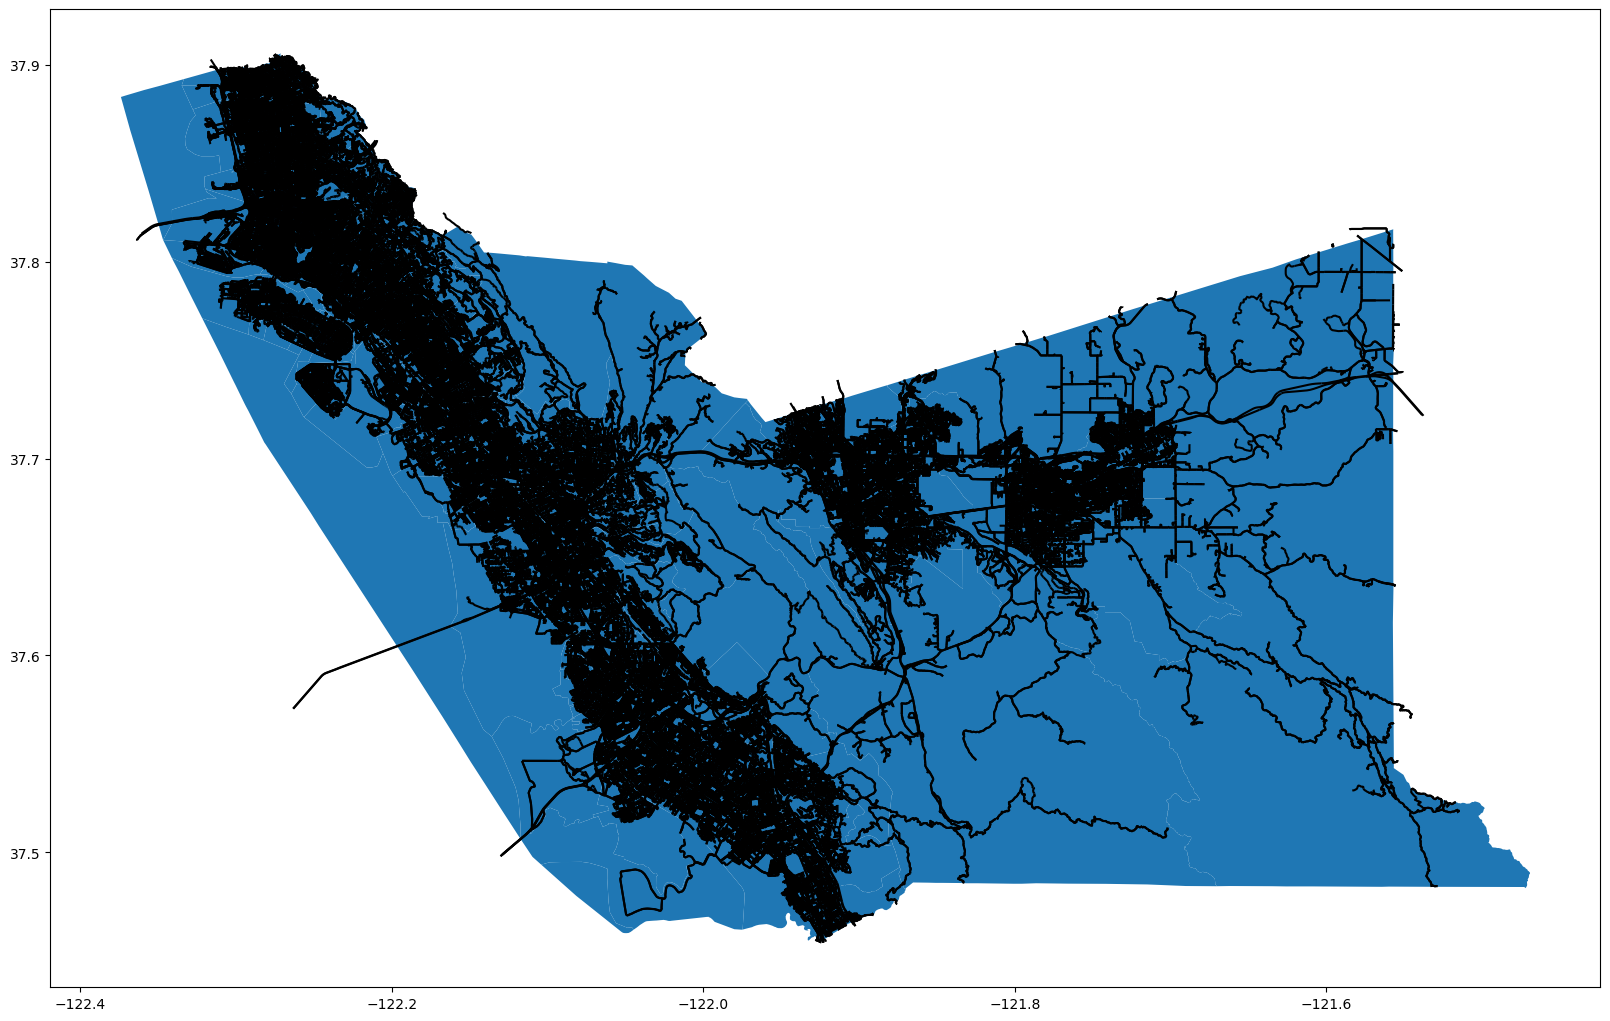

In [72]:
# Plot them to see how things are aligning so far
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax)
gdf_network_link_volumes.plot(ax=ax, color='black')
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].plot(ax=ax, color = 'pink')
gdf_TIMS.plot(ax=ax, color = 'blue')

In [2]:
# Interactive version
#!pip install folium
#!pip install mapclassify
import folium

m = shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].explore()
gdf_network_link_volumes.explore(
    m=m,
    color = 'black'
)
gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].explore(
    m=m,
    color='red',
    marker_kwds=dict(radius=5, fill=True)
)

folium.TileLayer("CartoDB positron", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)
m



# fig, ax = plt.subplots(figsize=(20, 15))
# shp_tl_CA_bgs_2020[shp_tl_CA_bgs_2020['countyfp'] == '001'].plot(ax=ax)
# gdf_network_link_volumes.plot(ax=ax, color='black')
# gdf_tagged_slip_lanes[gdf_tagged_slip_lanes['Valid']].plot(ax=ax, color = 'pink')

NameError: name 'shp_tl_CA_bgs_2020' is not defined